In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
currency_name = 'EURUSD'

In [3]:
df = pd.read_parquet('../Dataframes/df_' + currency_name + '.parquet.gzip')

In [4]:
df.head()

,date,open,high,low,close,delta,wclose,so_3,so_4,so_5,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,0.9852,0.9880,0.9787,0.9870,1.0,0.985175,46.111111,46.703297,54.245283,...,0.99210,0.98095,0.986525,0.98335,-11.260205,-86.842489,-127.321074,1.026691e-12,-330.457553,-470.787906
30,14/2/2000,0.9870,0.9915,0.9775,0.9782,0.0,0.981350,3.743316,3.645833,3.645833,...,0.98975,0.97810,0.983925,0.98450,130.182373,93.868922,50.385203,1.185661e+02,-162.025155,-458.671039
31,15/2/2000,0.9782,0.9864,0.9764,0.9816,1.0,0.981500,34.437086,26.262626,25.615764,...,0.98895,0.97695,0.982950,0.98140,299.264963,167.435835,159.017453,2.832998e+02,-45.808297,-438.109986
32,16/2/2000,0.9816,0.9873,0.9791,0.9865,1.0,0.984850,66.887417,66.887417,51.010101,...,0.98685,0.97775,0.982300,0.98320,-170.823122,-80.297689,120.035457,9.958985e+01,257.717291,-440.990540
33,17/2/2000,0.9865,0.9952,0.9842,0.9881,0.0,0.988900,62.234043,62.234043,62.234043,...,0.99125,0.98165,0.986450,0.98970,-106.779855,-137.317900,-148.249864,-1.570775e+02,135.034489,-446.398423


In [5]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [6]:
df.drop(columns=['delta'],inplace=True)

In [7]:
df.head()

,date,high,open,low,close,wclose,so_3,so_4,so_5,so_8,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,0.9880,0.9852,0.9787,0.9870,0.985175,46.111111,46.703297,54.245283,64.468864,...,0.99210,0.98095,0.986525,0.98335,-11.260205,-86.842489,-127.321074,1.026691e-12,-330.457553,-470.787906
30,14/2/2000,0.9915,0.9870,0.9775,0.9782,0.981350,3.743316,3.645833,3.645833,25.702811,...,0.98975,0.97810,0.983925,0.98450,130.182373,93.868922,50.385203,1.185661e+02,-162.025155,-458.671039
31,15/2/2000,0.9864,0.9782,0.9764,0.9816,0.981500,34.437086,26.262626,25.615764,30.414747,...,0.98895,0.97695,0.982950,0.98140,299.264963,167.435835,159.017453,2.832998e+02,-45.808297,-438.109986
32,16/2/2000,0.9873,0.9816,0.9791,0.9865,0.984850,66.887417,66.887417,51.010101,51.886792,...,0.98685,0.97775,0.982300,0.98320,-170.823122,-80.297689,120.035457,9.958985e+01,257.717291,-440.990540
33,17/2/2000,0.9952,0.9865,0.9842,0.9881,0.988900,62.234043,62.234043,62.234043,57.635468,...,0.99125,0.98165,0.986450,0.98970,-106.779855,-137.317900,-148.249864,-1.570775e+02,135.034489,-446.398423


### Change the normalization to be (0, 1)

In [8]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 30% of the data used for testing
test_size = int(.1 * (len(data)-lookback))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [9]:
input_features

array([[0.20171117, 0.20520456, 0.20390257, ..., 0.52966244, 0.45982857,
        0.31810799],
       [0.20624838, 0.20753496, 0.20233106, ..., 0.57336547, 0.52800556,
        0.32239176],
       [0.19963702, 0.1961419 , 0.20089052, ..., 0.63408566, 0.57504708,
        0.32966086],
       ...,
       [0.36310604, 0.36962714, 0.37139864, ..., 0.28873087, 0.21252906,
        0.19961307],
       [0.35934664, 0.36431901, 0.37192247, ..., 0.34224069, 0.21856941,
        0.18060641],
       [0.35908737, 0.36535474, 0.37179151, ..., 0.42384373, 0.21735928,
        0.14436055]])

In [10]:
input_data.shape

(5183, 33)

In [11]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

32

In [12]:
input_data

array([[0.20171117, 0.20520456, 0.20390257, ..., 0.52966244, 0.45982857,
        0.31810799],
       [0.20624838, 0.20753496, 0.20233106, ..., 0.57336547, 0.52800556,
        0.32239176],
       [0.19963702, 0.1961419 , 0.20089052, ..., 0.63408566, 0.57504708,
        0.32966086],
       ...,
       [0.36310604, 0.36962714, 0.37139864, ..., 0.28873087, 0.21252906,
        0.19961307],
       [0.35934664, 0.36431901, 0.37192247, ..., 0.34224069, 0.21856941,
        0.18060641],
       [0.35908737, 0.36535474, 0.37179151, ..., 0.42384373, 0.21735928,
        0.14436055]])

In [13]:
input_data[[0],1:]

array([[0.20520456, 0.20390257, 0.20753496, 0.20346278, 0.4986871 ,
        0.45091246, 0.49028242, 0.55385229, 0.57852838, 0.58445968,
        0.49612087, 0.52413284, 0.55385229, 0.57852838, 0.58445968,
        0.30543164, 0.32290487, 0.3211578 , 0.33097886, 0.19588276,
        0.46079171, 0.5040482 , 0.2045974 , 0.20623769, 0.20549605,
        0.2028013 , 0.74943699, 0.76738127, 0.68126495, 0.52966244,
        0.45982857, 0.31810799]])

In [14]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data)- lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [15]:
X

array([[[[0.20520456, 0.20390257, 0.20753496, ..., 0.52966244,
          0.45982857, 0.31810799]],

        [[0.20753496, 0.20233106, 0.1961419 , ..., 0.57336547,
          0.52800556, 0.32239176]],

        [[0.1961419 , 0.20089052, 0.20054376, ..., 0.63408566,
          0.57504708, 0.32966086]],

        ...,

        [[0.16235111, 0.15872184, 0.15277059, ..., 0.59982196,
          0.69326476, 0.3806512 ]],

        [[0.15277059, 0.14824515, 0.14746245, ..., 0.59677014,
          0.71361289, 0.41424468]],

        [[0.14746245, 0.14719749, 0.14409632, ..., 0.59548238,
          0.71855275, 0.45025502]]],


       [[[0.20753496, 0.20233106, 0.1961419 , ..., 0.57336547,
          0.52800556, 0.32239176]],

        [[0.1961419 , 0.20089052, 0.20054376, ..., 0.63408566,
          0.57504708, 0.32966086]],

        [[0.20054376, 0.2044264 , 0.20688762, ..., 0.56637088,
          0.69790623, 0.32864248]],

        ...,

        [[0.15277059, 0.14824515, 0.14746245, ..., 0.59677014,
       

In [16]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-test_size:]

# cut the test data out
X = X[:-(test_size)]
y = y[:-(test_size)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(4620, 50, 32)

In [17]:
file = "./Models/" + currency_name + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            7560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 22,231
Trainable params: 22,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4620/4620 [==============================] - 10s 2ms/step - loss: 0.0055
Epoch 2/5
4620/4620 [==============================] - 10s 2ms/step - loss: 4.9507e-04
Epoch 3/5
4620/4620 [==============================] - 8s 2ms/step - loss: 3.7

In [18]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size) + 1:,0]

In [19]:
actual_data = data.iloc[:, 1:].values[-(test_size) + 1:,0]
actual_data

array([1.2052, 1.1976, 1.2018, 1.2059, 1.2218, 1.2297, 1.2283, 1.2323,
       1.2265, 1.2295, 1.2275, 1.2306, 1.2415, 1.2537, 1.2494, 1.2442,
       1.2454, 1.2475, 1.2522, 1.2518, 1.2475, 1.2434, 1.2406, 1.2295,
       1.2287, 1.2297, 1.2371, 1.2465, 1.251 , 1.2555, 1.2435, 1.2412,
       1.236 , 1.2352, 1.2337, 1.2355, 1.2346, 1.2242, 1.2273, 1.2336,
       1.2365, 1.242 , 1.2444, 1.2446, 1.2334, 1.2345, 1.2407, 1.2413,
       1.2384, 1.2336, 1.2359, 1.2355, 1.235 , 1.2388, 1.2373, 1.2462,
       1.2476, 1.2422, 1.2335, 1.2331, 1.2345, 1.2336, 1.2315, 1.229 ,
       1.2291, 1.233 , 1.2378, 1.2396, 1.238 , 1.2346, 1.2395, 1.2414,
       1.2397, 1.24  , 1.2353, 1.2293, 1.2245, 1.2239, 1.221 , 1.2133,
       1.2139, 1.2084, 1.2032, 1.2009, 1.1996, 1.1978, 1.1939, 1.1897,
       1.1946, 1.1968, 1.1996, 1.1938, 1.1854, 1.1838, 1.1822, 1.1796,
       1.183 , 1.179 , 1.175 , 1.1734, 1.1728, 1.164 , 1.1676, 1.1724,
       1.1718, 1.1745, 1.1732, 1.1796, 1.184 , 1.181 , 1.1821, 1.1809,
      

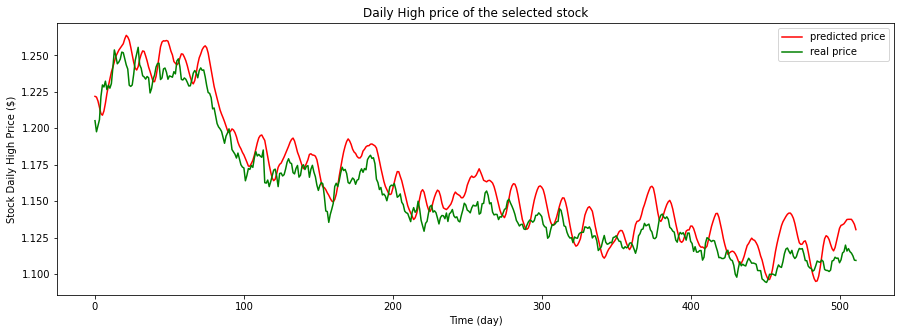

In [20]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [21]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [22]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']
frame

,actual,predict,p1,diff1
0,1.2052,1.221873,NaN,NaN
1,1.1976,1.221375,1.221873,-0.000498
2,1.2018,1.218678,1.221375,-0.002697
3,1.2059,1.214479,1.218678,-0.004198
4,1.2218,1.210008,1.214479,-0.004471
...,...,...,...,...
507,1.1154,1.137570,1.137579,-0.000009
508,1.1144,1.137574,1.137570,0.000004
509,1.1125,1.136080,1.137574,-0.001494
510,1.1096,1.134121,1.136080,-0.001960


In [23]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 200

In [24]:
frame['wclose'] = data['wclose'].values[-(test_size) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,1.2052,1.221873,NaN,NaN,NaN,1.198550,NaN
1,1.1976,1.221375,1.221873,-0.000498,-0.083174,1.194150,-0.003671
2,1.2018,1.218678,1.221375,-0.002697,-0.448902,1.195925,0.001486
3,1.2059,1.214479,1.218678,-0.004198,-0.696312,1.201300,0.004494
4,1.2218,1.210008,1.214479,-0.004471,-0.731916,1.216075,0.012299
5,1.2297,1.208950,1.210008,-0.001058,-0.172101,1.225325,0.007606
6,1.2283,1.211831,1.208950,0.002881,0.469111,1.224950,-0.000306
7,1.2323,1.217188,1.211831,0.005357,0.869359,1.221800,-0.002572
8,1.2265,1.223703,1.217188,0.006515,1.062376,1.222650,0.000696
9,1.2295,1.229030,1.223703,0.005327,0.866605,1.226300,0.002985


In [25]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

In [26]:
cumsum = frame['daily_pnl'].cumsum()

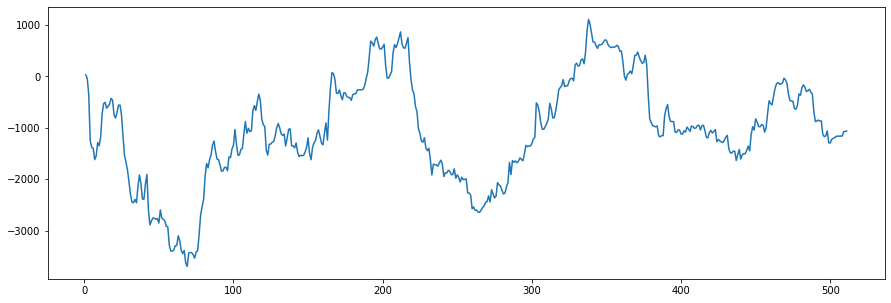

In [27]:
plt.figure(figsize=(15,5))
plt.plot(cumsum)
plt.show()

In [28]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

-0.20464780593767873

In [29]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

1.032

In [30]:
# maximum drawdown
maxm = 0
drawdown = 0
cur_low = 0
size = len(cumsum)

final_start = 0
final_end = 0

start_date = 0
end_date = 0

for i in range(1, size):
    cur_val = cumsum[i]
    if cur_val >= maxm:
        
        drawdown = max(drawdown, maxm - cur_low)
        
        if drawdown == maxm - cur_low:
            final_start = start_date
            final_end = end_date
            
        maxm = cur_val
        cur_low = cur_val
        
        start_date = i
    else:
        cur_low = min(cur_low, cur_val)
        if cur_low == cur_val:
            end_date = i

print('drawdown is:', drawdown, ', from day', final_start, ', to day', final_end)

drawdown is: 3726.6182152192846 , from day 1 , to day 69
